# PCA + K-means로 Spectral Clustering 을 직접구현해보자
그래프(graph) 기반 군집화 기법인 Spectral Clustering.


## scikit-learn (Comparing different clustering algorithms on toy datasets)을 참고했습니다
우선은 SpectralClustering, KernelKMeans을 비교해보았습니다<br>

In [1]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)

plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2})]



In [2]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.utils import check_random_state

class KernelKMeans(BaseEstimator, ClusterMixin):
    """
    Kernel K-means

    Reference
    ---------
    Kernel k-means, Spectral Clustering and Normalized Cuts.
    Inderjit S. Dhillon, Yuqiang Guan, Brian Kulis.
    KDD 2004.
    """

    def __init__(self, n_clusters=3, max_iter=50, tol=1e-3, random_state=None,
                 kernel="linear", gamma=None, degree=3, coef0=1,
                 kernel_params=None, verbose=0):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        self.kernel_params = kernel_params
        self.verbose = verbose

    @property
    def _pairwise(self):
        return self.kernel == "precomputed"

    def _get_kernel(self, X, Y=None):
        if callable(self.kernel):
            params = self.kernel_params or {}
        else:
            params = {"gamma": self.gamma,
                      "degree": self.degree,
                      "coef0": self.coef0}
        return pairwise_kernels(X, Y, metric=self.kernel,
                                filter_params=True, **params)

    def fit(self, X, y=None, sample_weight=None):
        n_samples = X.shape[0]

        K = self._get_kernel(X)

        sw = sample_weight if sample_weight else np.ones(n_samples)
        self.sample_weight_ = sw

        rs = check_random_state(self.random_state)
        self.labels_ = rs.randint(self.n_clusters, size=n_samples)

        dist = np.zeros((n_samples, self.n_clusters))
        self.within_distances_ = np.zeros(self.n_clusters)

        for it in range(self.max_iter):
            dist.fill(0)
            self._compute_dist(K, dist, self.within_distances_,
                               update_within=True)
            labels_old = self.labels_
            self.labels_ = dist.argmin(axis=1)

            # Compute the number of samples whose cluster did not change
            # since last iteration.
            n_same = np.sum((self.labels_ - labels_old) == 0)
            if 1 - float(n_same) / n_samples < self.tol:
                if self.verbose:
                    print ("Converged at iteration", it + 1)
                break

        self.X_fit_ = X

        return self

    def _compute_dist(self, K, dist, within_distances, update_within):
        """Compute a n_samples x n_clusters distance matrix using the
        kernel trick."""
        sw = self.sample_weight_

        for j in range(self.n_clusters):
            mask = self.labels_ == j

            if np.sum(mask) == 0:
                raise ValueError("Empty cluster found, try smaller n_cluster.")

            denom = sw[mask].sum()
            denomsq = denom * denom

            if update_within:
                KK = K[mask][:, mask]  # K[mask, mask] does not work.
                dist_j = np.sum(np.outer(sw[mask], sw[mask]) * KK / denomsq)
                within_distances[j] = dist_j
                dist[:, j] += dist_j
            else:
                dist[:, j] += within_distances[j]

            dist[:, j] -= 2 * np.sum(sw[mask] * K[:, mask], axis=1) / denom

    def predict(self, X):
        K = self._get_kernel(X, self.X_fit_)
        n_samples = X.shape[0]
        dist = np.zeros((n_samples, self.n_clusters))
        self._compute_dist(K, dist, self.within_distances_,
                           update_within=False)
        return dist.argmin(axis=1)

Converged at iteration 6
Converged at iteration 4


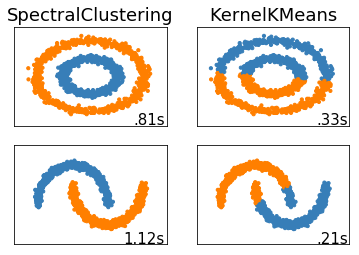

In [3]:
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    km = KernelKMeans(n_clusters=2, max_iter=100, random_state=0, verbose=1)
    
    clustering_algorithms = (
        ('SpectralClustering', spectral),
        ('KernelKMeans', km)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()


    step1. Gaussian kernel을 통해 pairwise affinity(dist)
    step2. L = D - A
    step3. eigenvalue (L)
    step4. K=2, eigenvector
    step5. kmeans(L)
    step6. original data 적용
    
    
### 데이터에서 인접행렬을 만들때는 가우시안 커널을 사용합니다

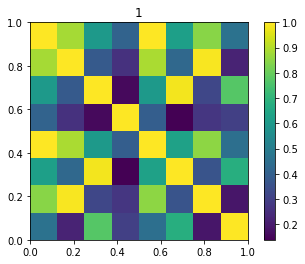

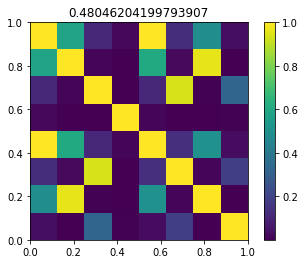

In [4]:
from sklearn import cluster, datasets, mixture
from scipy.spatial.distance import pdist, squareform

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
X, y = noisy_circles

def gausker(x1,x2,sigma):
    dist = np.linalg.norm(x1-x2)
    return np.exp(-dist**2/(2.*(sigma**2.)))

data = X
s = np.std(pdist(data))
for sigma in [1, s]:
    gaus = np.zeros((8,8))
    for ii in range(8):
        for jj in range(8):
            gaus[ii,jj] = gausker(data[ii,:],data[jj,:],sigma)
    plt.figure()
    plt.imshow(gaus,extent=[0, 1, 0, 1])
    plt.colorbar()
    plt.title(str(sigma))
    plt.show()

0.0

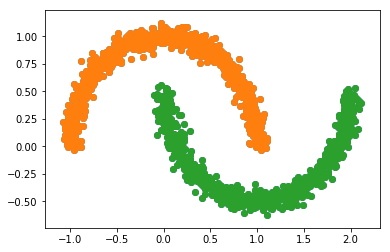

In [5]:
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)

dataset = noisy_moons[0]
labels = noisy_moons[1]

dataset[:,0]
plt.scatter(dataset[:,0], dataset[:,1])

data_0 = dataset[labels == 0]
plt.scatter(data_0[:,0], data_0[:,1])
data_1 = dataset[labels == 1]
plt.scatter(data_1[:,0], data_1[:,1])

sigma = np.std(pdist(data))
gausker(data_0,data_1,sigma)

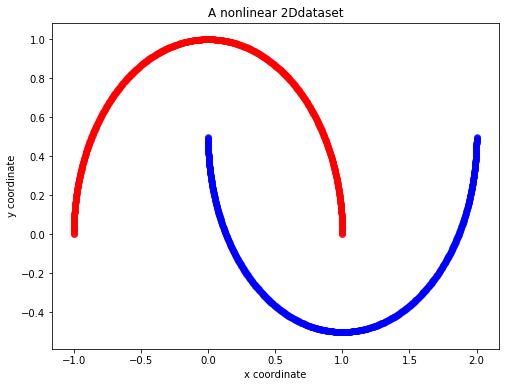

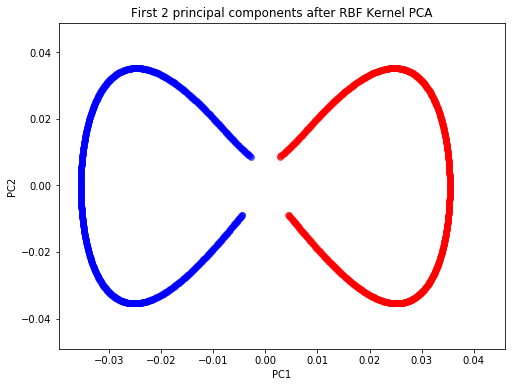

In [6]:
from scipy import exp
from scipy.linalg import eigh
import numpy as np
from sklearn.cluster import KMeans
from scipy.sparse import csgraph

X, y = datasets.make_moons(n_samples=1500, random_state=123)

def stepwise_kpca(X, gamma, n_components):
    sq_dists = pdist(X, 'sqeuclidean')
    mat_sq_dists = squareform(sq_dists)
    K = exp(-gamma * mat_sq_dists)
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    eigvals, eigvecs = eigh(K)
    X_pc = np.column_stack((eigvecs[:,-i] for i in range(1,n_components+1)))
    return X_pc

plt.figure(figsize=(8,6))
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
plt.title('A nonlinear 2Ddataset')
plt.ylabel('y coordinate')
plt.xlabel('x coordinate')
plt.show()

X_pc = stepwise_kpca(X, gamma=15, n_components=2)
plt.figure(figsize=(8,6))
plt.scatter(X_pc[y==0, 0], X_pc[y==0, 1], color='red', alpha=0.5)
plt.scatter(X_pc[y==1, 0], X_pc[y==1, 1], color='blue', alpha=0.5)
plt.title('First 2 principal components after RBF Kernel PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

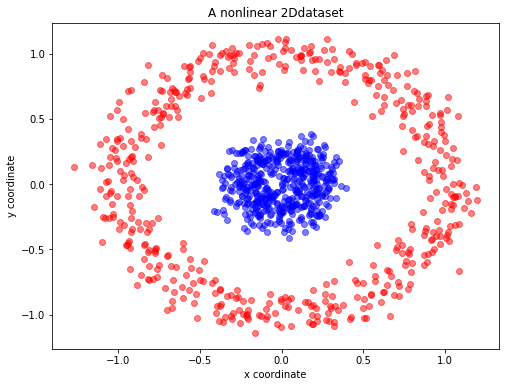

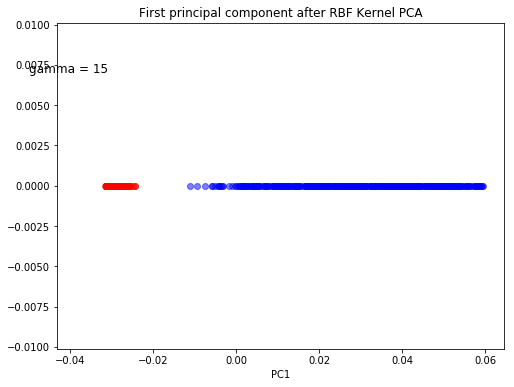

In [7]:
X, y = datasets.make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.figure(figsize=(8,6))
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
plt.title('A nonlinear 2Ddataset')
plt.ylabel('y coordinate')
plt.xlabel('x coordinate')
plt.show()

X_pc = stepwise_kpca(X, gamma=15, n_components=1)
plt.figure(figsize=(8,6))
plt.scatter(X_pc[y==0, 0], np.zeros((500,1)), color='red', alpha=0.5)
plt.scatter(X_pc[y==1, 0], np.zeros((500,1)), color='blue', alpha=0.5)
plt.text(-0.05, 0.007, 'gamma = 15', fontsize=12)
plt.title('First principal component after RBF Kernel PCA')
plt.xlabel('PC1')
plt.show()

S  for dataset using the gaussian kernel:

In [8]:
X, y = datasets.make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)
gamma = 1
n_components=1000

sq_dists = pdist(X, 'sqeuclidean')
mat_sq_dists = squareform(sq_dists)
S = exp(-gamma * mat_sq_dists)
S

array([[1.        , 0.42636604, 0.2901563 , ..., 0.0116931 , 0.01285952,
        0.37432911],
       [0.42636604, 1.        , 0.06790046, ..., 0.02682376, 0.05606269,
        0.451431  ],
       [0.2901563 , 0.06790046, 1.        , ..., 0.10743102, 0.05676923,
        0.42742652],
       ...,
       [0.0116931 , 0.02682376, 0.10743102, ..., 1.        , 0.83720069,
        0.27214145],
       [0.01285952, 0.05606269, 0.05676923, ..., 0.83720069, 1.        ,
        0.30012299],
       [0.37432911, 0.451431  , 0.42742652, ..., 0.27214145, 0.30012299,
        1.        ]])

In [9]:
# N = S.shape[0]
# one_n = np.ones((N,N)) / N
# S = S - one_n.dot(S) - S.dot(one_n) + one_n.dot(S.dot(one_n))
# S                                                
# eigvals, eigvecs = eigh(S)
# X_pc = np.column_stack((eigvecs[:,-i] for i in range(1,n_components+1)))
# X_pc

In [231]:
N = S.shape[0]
neighbors = 3
A = np.zeros((N,N))

# neighbor_indices = S[0,].argsort()
# neighbor_indices

neighbor_indices = sorted(S[0,])[N-neighbors:N]
neighbor_indices
# for s in neighbor_indices:
#     j = np.where(S[0,] == s)[0][0]
#     print(j)
# S[i,]

# for i in range(N):
#     neighbor_indices = sorted(S[i,])[N-neighbors:N]
#     for s in neighbor_indices:
#           j = np.where(S[i,] == s)[]          
#           A[i,j] = S[i, j]
#           A[j,i] = S[i, j]


            
#             matchings_indices = [ i for i, x in enumerate(x) if x == value ]
# for i in range(0,nData):
#         neighbor_indices =sorted(similarityMatrix[i,])[1:neighbor]
#         for s in neighbor_indices:
#             if(similarityMatrix[i,] == s):
#                 j = similarityMatrix[i,].index(s)    
#                 result[i,j] = similarityMatrix[i, j]
#                 result[j,i] = similarityMatrix[i, j]
#     return result
# A
            
        

[0.9989134182207084, 0.9991836356258469, 1.0]

In [188]:
def RbfKernel(data1, data2, sigma):
    delta =np.matrix(abs(np.subtract(data1, data2)))
    squaredEuclidean = (np.square(delta).sum(axis=1))
    result = np.exp(-(squaredEuclidean)/(2*sigma**2))
    return result


In [189]:
var = 1.5
k = 2 #number of clusters
n = 3 #number of neighbor
import operator 

def buildSimmilarityMatrix(dataIn):
    nData = dataIn.shape[0]
    result = np.matrix(np.full((nData,nData), 0, dtype=np.float))
    for i in range(0,nData):
        for j in range(0, nData):
            weight = RbfKernel(dataIn[i, :], dataIn[j, :], var)
            result[i,j] = weight
    return result

def buildDegreeMatrix(affinityMatrix):
    diag = np.array(affinityMatrix.sum(axis=1)).ravel()
    result = np.diag(diag)
    return result

def unnormalizedLaplacian(simMatrix, degMatrix):
    result = degMatrix - simMatrix
    return result


In [190]:
from scipy import linalg as LA


def transformToSpectral(laplacian):
    global k
    e_vals, e_vecs = LA.eig(np.matrix(laplacian))
    ind = e_vals.real.argsort()[:k]
    result = np.ndarray(shape=(laplacian.shape[0],0))
    for i in range(1, ind.shape[0]):
        cor_e_vec = np.transpose(np.matrix(e_vecs[:,np.asscalar(ind[i])]))
        result = np.concatenate((result, cor_e_vec), axis=1)
    return result

In [191]:
X, y = datasets.make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

simMat = buildSimmilarityMatrix(X)

In [215]:
simMat

matrix([[1.        , 0.82742658, 0.75959988, ..., 0.37209261, 0.38003859,
         0.80383603],
        [0.82742658, 1.        , 0.55006772, ..., 0.44748879, 0.52714189,
         0.83799713],
        [0.75959988, 0.55006772, 1.        , ..., 0.60910966, 0.52861103,
         0.82788347],
        ...,
        [0.37209261, 0.44748879, 0.60910966, ..., 1.        , 0.96128246,
         0.74885688],
        [0.38003859, 0.52714189, 0.52861103, ..., 0.96128246, 1.        ,
         0.76532215],
        [0.80383603, 0.83799713, 0.82788347, ..., 0.74885688, 0.76532215,
         1.        ]])

In [238]:
def buildAffinityMatrix(similarityMatrix, neighbor):
    nData = similarityMatrix.shape[0]  
    result = np.matrix(np.full((nData,nData), 0, dtype=np.float))   
    for i in range(0, nData):        
        neighbor_indices = sorted(similarityMatrix[i,])[nData-neighbor:nData]
#         print(neighbor_indices)
        for s in neighbor_indices:           
            j = np.where(similarityMatrix[i,] == s)[0][0]
            result[i,j] = similarityMatrix[i, j]
            result[j,i] = similarityMatrix[i, j]
    return result

affMat = buildAffinityMatrix(simMat, n)

In [239]:
affMat

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
degMat = buildDegreeMatrix(affMat)
lapMat = unnormalizedLaplacian(simMat, degMat)
transformedData = transformToSpectral(lapMat)

In [129]:
simMat

matrix([[1.        , 0.82742658, 0.75959988, ..., 0.37209261, 0.38003859,
         0.80383603],
        [0.82742658, 1.        , 0.55006772, ..., 0.44748879, 0.52714189,
         0.83799713],
        [0.75959988, 0.55006772, 1.        , ..., 0.60910966, 0.52861103,
         0.82788347],
        ...,
        [0.37209261, 0.44748879, 0.60910966, ..., 1.        , 0.96128246,
         0.74885688],
        [0.38003859, 0.52714189, 0.52861103, ..., 0.96128246, 1.        ,
         0.76532215],
        [0.80383603, 0.83799713, 0.82788347, ..., 0.74885688, 0.76532215,
         1.        ]])

In [130]:
affMat

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [76]:
degMat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [77]:
lapMat

matrix([[-1.        , -0.82742658, -0.75959988, ..., -0.37209261,
         -0.38003859, -0.80383603],
        [-0.82742658, -1.        , -0.55006772, ..., -0.44748879,
         -0.52714189, -0.83799713],
        [-0.75959988, -0.55006772, -1.        , ..., -0.60910966,
         -0.52861103, -0.82788347],
        ...,
        [-0.37209261, -0.44748879, -0.60910966, ..., -1.        ,
         -0.96128246, -0.74885688],
        [-0.38003859, -0.52714189, -0.52861103, ..., -0.96128246,
         -1.        , -0.76532215],
        [-0.80383603, -0.83799713, -0.82788347, ..., -0.74885688,
         -0.76532215, -1.        ]])

In [62]:
transformedData

matrix([[-0.0148183 ,  0.05954495],
        [-0.03524306,  0.01408983],
        [ 0.02097966,  0.01938031],
        ...,
        [ 0.01861804, -0.04053919],
        [ 0.00156692, -0.04199947],
        [-0.00164223,  0.0016042 ]])

In [67]:
from sklearn.cluster import KMeans
X_tran = transformedData

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_tran)
# y_kmeans = kmeans.predict(X_tran)
# kmeans.labels_

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

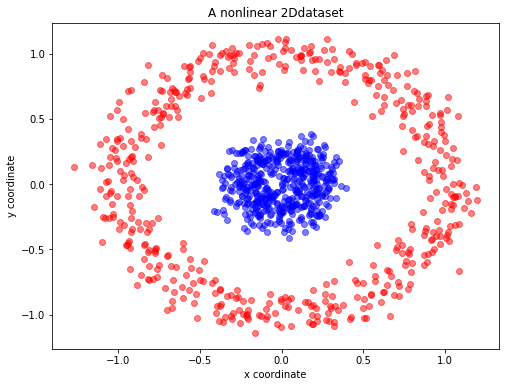

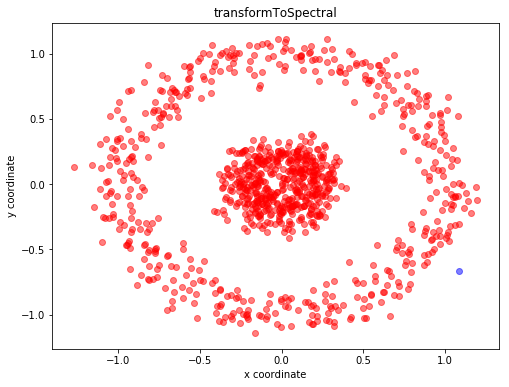

In [70]:
plt.figure(figsize=(8,6))
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
plt.title('A nonlinear 2Ddataset')
plt.ylabel('y coordinate')
plt.xlabel('x coordinate')
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(X[kmeans.labels_==0, 0], X[kmeans.labels_==0, 1], color='red', alpha=0.5)
plt.scatter(X[kmeans.labels_==1, 0], X[kmeans.labels_==1, 1], color='blue', alpha=0.5)
plt.title('transformToSpectral')
plt.ylabel('y coordinate')
plt.xlabel('x coordinate')
plt.show()

Ratsgo's blog - Spectral Clustering [https://ratsgo.github.io/machine%20learning/2017/04/27/spectral/]